 # Library Imports & Seed Value

In [1]:
!pip install -r requirements.txt

In [2]:
import warnings
import warnings
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import xgboost as xgb
import seaborn as sns
import torch.nn as nn
import xgboost as xgb
import torch.nn as nn

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.cross_decomposition import PLSRegression


SEED = 42

In [3]:
def print_full(df: pd.DataFrame):
    """
    Helper function that prints the entire DataFrame without truncation for inspection.
    """
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print(df)

# Exploing the Data

In [4]:
prices = pd.read_csv("prices2.csv")
prices.head()

,date,ticker,open,high,low,close,adj_close,volume
0,2010-01-04,XLE,57.919998,58.810001,57.790001,58.810001,35.058506,16928400
1,2010-01-05,XLE,58.889999,59.410000,58.619999,59.290001,35.344662,17368100
2,2010-01-06,XLE,59.320000,60.180000,59.189999,60.000000,35.767918,24351900
3,2010-01-07,XLE,59.740002,60.009998,59.299999,59.910000,35.714241,17449500
4,2010-01-08,XLE,59.700001,60.349998,59.490002,60.299999,35.946747,13344300


In [5]:
prices.describe()

,open,high,low,close,adj_close,volume
count,22638.000000,22638.000000,22638.000000,22638.000000,22638.000000,2.263800e+04
mean,63.400635,63.828433,62.947446,63.408916,55.077096,2.090476e+07
std,37.647514,37.912580,37.362088,37.651167,37.798705,2.613029e+07
min,9.041430,9.512591,8.895207,9.163282,7.068153,8.352000e+05
25%,34.750000,34.950001,34.492501,34.752500,28.154113,7.681825e+06
50%,57.000000,57.369999,56.655001,57.045000,45.106310,1.153935e+07
75%,78.657503,79.190002,78.050003,78.580002,69.174141,2.138755e+07
max,240.789993,241.880005,240.070007,241.440002,239.916107,4.685334e+08


In [6]:
prices.isna().sum()

date         0
ticker       0
open         0
high         0
low          0
close        0
adj_close    0
volume       0
dtype: int64

In [7]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22638 entries, 0 to 22637
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       22638 non-null  object 
 1   ticker     22638 non-null  object 
 2   open       22638 non-null  float64
 3   high       22638 non-null  float64
 4   low        22638 non-null  float64
 5   close      22638 non-null  float64
 6   adj_close  22638 non-null  float64
 7   volume     22638 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 1.4+ MB


Changing the date column to the data type `datetime` for proper date handling when accessing data by date.

In [8]:
prices['date'] = pd.to_datetime(prices['date'])

List the number of unique tickers.

In [9]:
tickers = prices['ticker'].unique()
print("List of all tickers in the dataset : \n", tickers)

List of all tickers in the dataset : 
 ['XLE' 'XLF' 'XLI' 'XLK' 'XLP' 'XLV']


### Plotting Stock Price Over time & Log Return for Each Ticker 

$$
r_t = \ln\left(\frac{P_t}{P_{t-1}}\right)
$$


In our implementation were using log returns instead of simple returns as it's better for time additivity, symmetry, and scaling. This can be seen in the plots below of the simple returns and log returns.

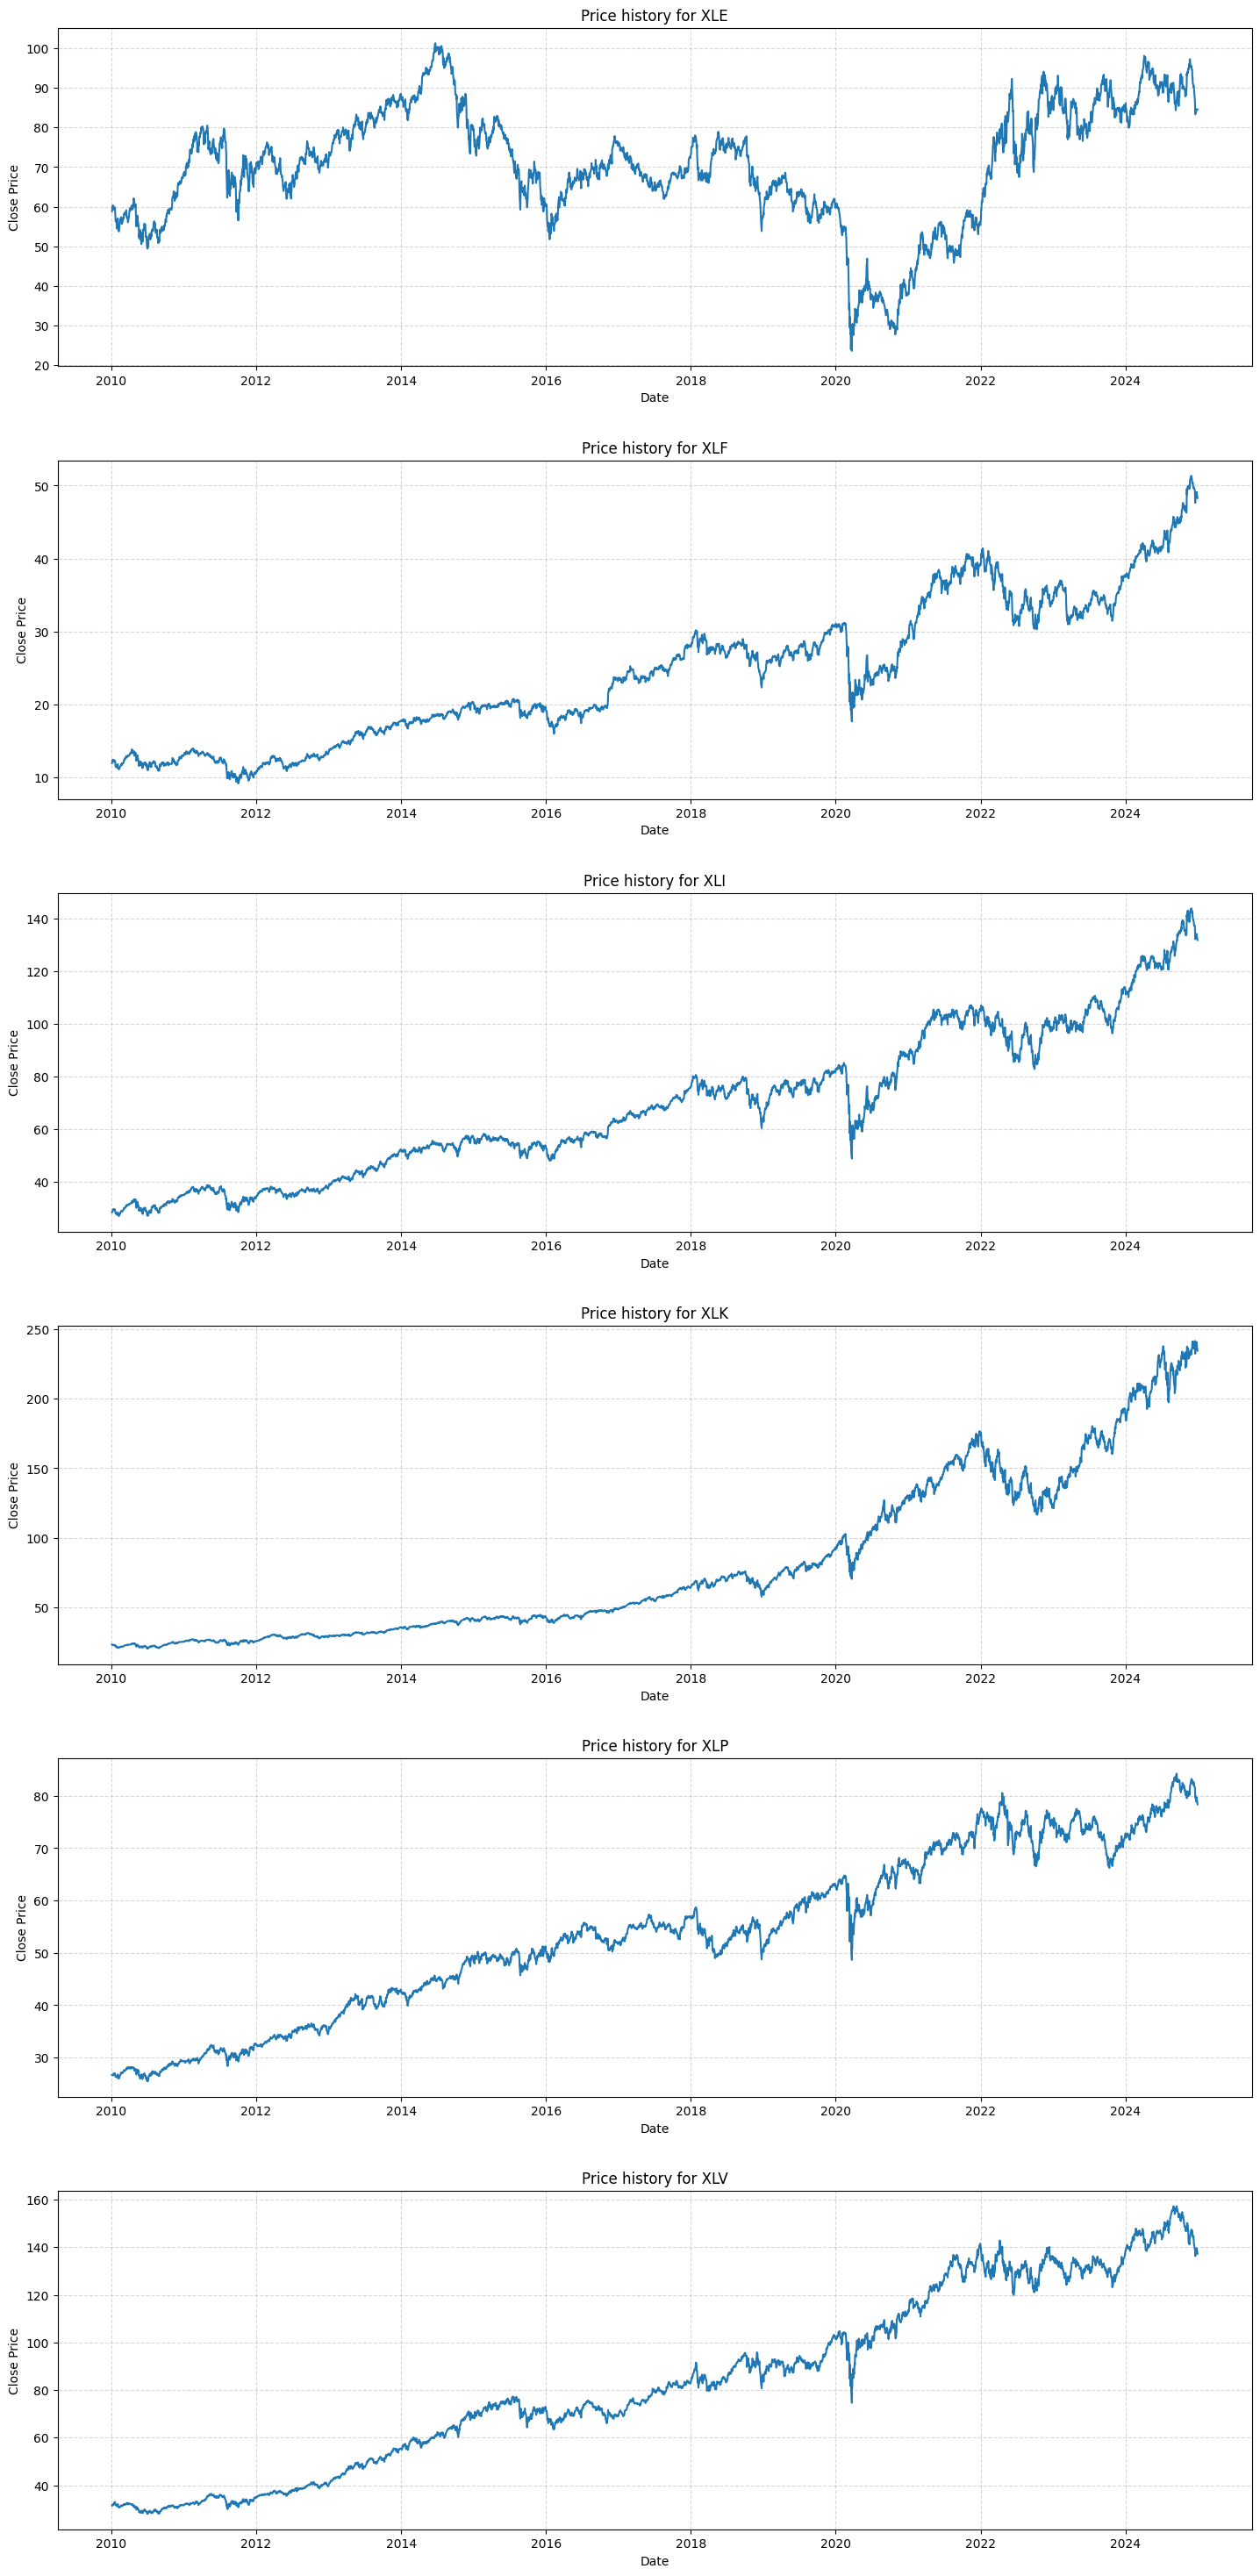

In [10]:
num_tickers = len(tickers)
fig, axes = plt.subplots(6, 1, figsize=(15, 30))  
axes = axes.flatten() 

for i, ticker in enumerate(tickers):
    ticker_df = prices[prices['ticker'] == ticker]

    axes[i].plot(ticker_df['date'], ticker_df['close'], label=ticker)

    axes[i].set_title(f'Price history for {ticker}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Close Price')
    axes[i].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(pad=3.0)
plt.show()


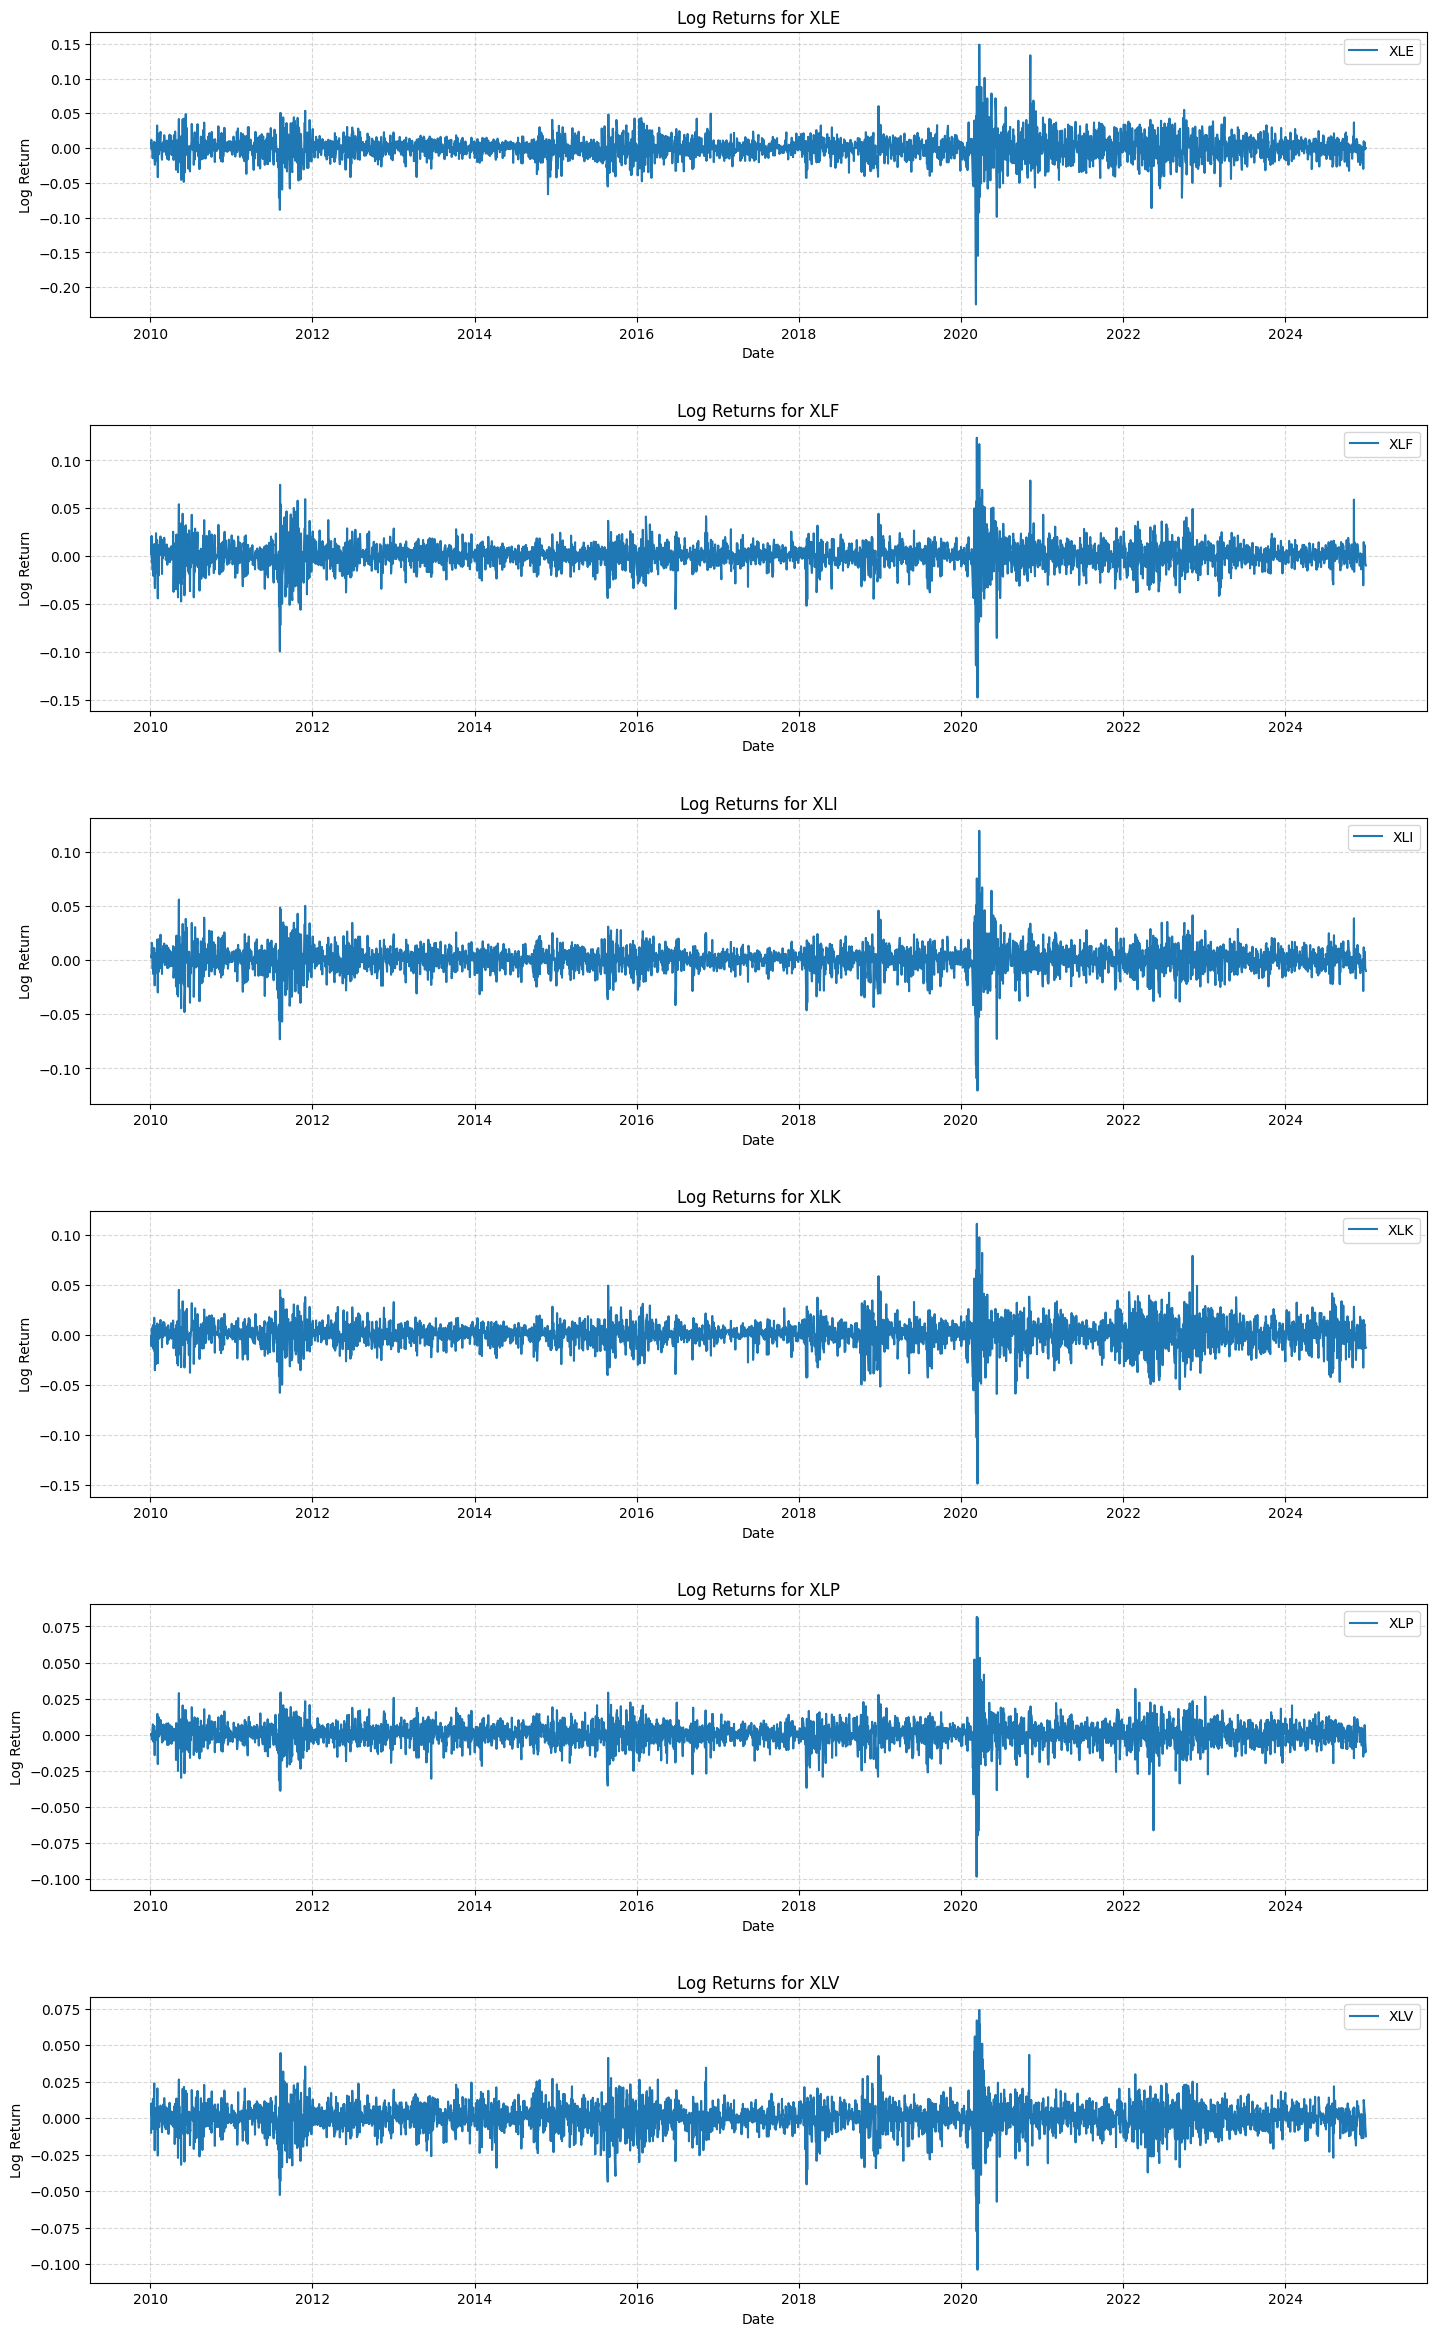

In [11]:
fig, axes = plt.subplots(6, 1, figsize=(15, 24)) 
axes = np.array(axes).flatten()  

for i, ticker in enumerate(tickers):
    ticker_df = prices[prices['ticker'] == ticker].sort_values('date').copy()
    
    ticker_df['log_return'] = np.log(ticker_df['close'] / ticker_df['close'].shift(1))
    
    axes[i].plot(ticker_df['date'], ticker_df['log_return'], label=ticker, color='tab:blue')    
    axes[i].set_title(f'Log Returns for {ticker}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Log Return')
    axes[i].grid(True, linestyle='--', alpha=0.5)
    axes[i].legend()

plt.tight_layout(pad=3.0)
plt.show()



# Feature Engineering
##### The data only has three columns and only one is quantitative, so using what we have, we calculate new features commonly used by statisticians to predict stock prices. 

Sources :

- [Predicting Stock Returns: A Guide to Feature Engineering for Financial Data ](https://medium.com/@zhonghong9998/predicting-stock-returns-a-guide-to-feature-engineering-for-financial-data-bbf6700b11d7)

- [Useful features in Predicting Stock Prices
](https://www.kaggle.com/code/riteshsinha/useful-features-in-predicting-stock-prices)

| Feature                 | How Computed                | Intuition / Significance                              |
| ----------------------- | --------------------------- | ----------------------------------------------------- |
| Lagged log return       | $ ( \ln(P_{t-i}/P_{t-i-1}) ) $  | Short-term autocorrelation, momentum/reversion signal |
| Rolling mean / momentum | Mean of past N log returns  | Smooth trend direction, captures momentum             |
| Rolling volatility      | Std of past N log returns   | Measures risk, magnitude of potential moves           |
| RSI                     | $ 1 - 1/(1 + AvgGain/AvgLoss) $ | Overbought/oversold, predicts reversals               |
| SMA/EMA distance        | $ (P - MA)/MA $                | Trend deviation, signals potential corrections        |
| MACD                    | $ EMA_f - EMA_s $         | Momentum shift, trend change                          |
| Bollinger Bands         | $ MA ± 2 × vol $                | Expected price range, reversal/breakout indicator     |
| Volume ratio            | $ Current / average volume $    | Confirms strength of move, detects spikes             |



#### Daily Log Return $$ ( \ln(P_{t-i}/P_{t-i-1}) ) $$

In [12]:
prices['log_return'] = prices.groupby('ticker')['close'].transform(lambda x: np.log(x / x.shift(1)))

#### Rolling Momentum (mean) & Volatility (standard deviation) of past N days

<center> Mean and Standard Deviation of past N log returns </center>

In [13]:
windows = [5, 10, 20]

for w in windows:
    prices[f'mom_{w}'] = prices.groupby('ticker')['log_return'].transform(
        lambda x: x.rolling(window=w, min_periods=w).mean()
    )

    prices[f'vol_{w}'] = prices.groupby('ticker')['log_return'].transform(
        lambda x: x.rolling(window=w, min_periods=w).std()
    )



#### Relative Strength Index (RSI) of past 14 days  $$ 1 - 1/(1 + AvgGain/AvgLoss) $$

In [14]:
def compute_rsi(x, window=14):
    delta = x.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_gain = gain.ewm(alpha=1/window, adjust=False, min_periods=window).mean()
    avg_loss = loss.ewm(alpha=1/window, adjust=False, min_periods=window).mean()

    rs = avg_gain / avg_loss.replace(0, np.nan)
    rsi = 1 - (1 / (1 + rs))
    # setting Nan values to 0.5 which is a neutral value and does not have any adverse effects on the model
    return rsi.fillna(0.5) 

prices['rsi_14'] = prices.groupby('ticker')['close'].transform(compute_rsi)


#### Simple Moving Average (SMA) distance $$ (P - MA)/MA $$

In [15]:
sma_windows = [10, 20]
for window in sma_windows:
    prices[f'sma_dist_{window}'] = (prices['close'] - prices.groupby('ticker')['close'].transform(lambda x: x.rolling(window, min_periods=window).mean())) / prices.groupby('ticker')['close'].transform(lambda x : x.rolling(window, min_periods=window).mean())

#### Lagged Returns
 <center> Past log returns for N days 

In [16]:
lags = [1,2,3,5]  
for lag in lags:
    prices[f'lag_{lag}'] = prices.groupby('ticker')['log_return'].shift(lag)


#### Moving Average Convergence Divergence (MACD) 
$$
 MACD = EMA_{12} - EMA_{26}   
$$
$$
 Signal = EMA_9
$$
$$
Histogram = MACD - Signal
$$

- $ macd $: main trend/momentum indicator
- $ macd_{signal} $: smoothed signal line
- $ macd_{hist} $: strength/direction of momentum shift

MACD shows the relationship between two moving averages (12-day and 26-day).
Signal Line (9-day EMA of MACD) helps identify buy/sell signals.
Significance:
- When $ MACD $ > Signal Line, it indicates bullish momentum (buy).
- When $ MACD $ < Signal Line, it signals bearish momentum (sell).

In [17]:
def compute_macd(df, short=12, long=26, signal=9):
    ema_short = df['close'].ewm(span=short, adjust=False).mean()
    ema_long = df['close'].ewm(span=long, adjust=False).mean()
    macd = ema_short - ema_long
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    hist = macd - signal_line
    return macd, signal_line, hist

prices[['macd', 'macd_signal', 'macd_hist']] = prices.groupby('ticker', group_keys=False).apply(
    lambda x : pd.DataFrame(np.column_stack(compute_macd(x)), index=x.index)
)


/tmp/ipykernel_4807/2819629551.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  prices[['macd', 'macd_signal', 'macd_hist']] = prices.groupby('ticker', group_keys=False).apply(


#### Bollinger Bands 
$$ MA ± 2 × vol $$


Features Added
- Middle Band = $ Rolling Mean $ 
- Upper Band = $ Mean + 2 × Rolling Std $
- Lower Band = $ Mean − 2 × Rolling Std $
- Bandwidth = $ (Upper − Lower) / Middle $

Bollinger Bands show volatility around a moving average.
- When the price touches the upper band, it might be overbought.
- When it touches the lower band, it might be oversold.
- Wider bands mean higher volatility; narrow bands mean lower volatility.



In [18]:
def compute_bbands(df, window=20, num_std=2):
    rolling_mean = df['mom_20']
    rolling_std = df['vol_20']
    upper = rolling_mean + (num_std * rolling_std)
    lower = rolling_mean - (num_std * rolling_std)
    bandwidth = (upper - lower) / rolling_mean
    return upper, lower, bandwidth

prices[['bb_upper', 'bb_lower', 'bb_bandwidth']] = prices.groupby('ticker', group_keys=False).apply(
    lambda x: pd.DataFrame(np.column_stack(compute_bbands(x)), index=x.index)
)


/tmp/ipykernel_4807/1181734782.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  prices[['bb_upper', 'bb_lower', 'bb_bandwidth']] = prices.groupby('ticker', group_keys=False).apply(


#### Volume Ratio (VR)
$$
Current / Average Volume 
$$

Compares buying vs. selling pressure over a period.

- $ VR $ > 1 - more buying volume : bullish signal (buy).
- $ VR $ < 1 - more selling volume : bearish signal (sell).

In [19]:
window = 20

# Identifying up and down days
prices['up_vol'] = np.where(prices['close'] > prices['close'].shift(1), prices['volume'], 0)
prices['down_vol'] = np.where(prices['close'] < prices['close'].shift(1), prices['volume'], 0)

# Computing rolling sums
prices['up_vol_rolling'] = prices['up_vol'].rolling(window).sum()
prices['down_vol_rolling'] = prices['down_vol'].rolling(window).sum()

# Computing Volume Ratio
prices['Volume_Ratio'] = prices['up_vol_rolling'] / prices['down_vol_rolling']


##### After aadding all these features, lets take a look at the data 

In [20]:
prices

,date,ticker,open,high,low,close,adj_close,volume,log_return,mom_5,...,macd_signal,macd_hist,bb_upper,bb_lower,bb_bandwidth,up_vol,down_vol,up_vol_rolling,down_vol_rolling,Volume_Ratio
0,2010-01-04,XLE,57.919998,58.810001,57.790001,58.810001,35.058506,16928400,NaN,NaN,...,0.000000,0.000000,NaN,NaN,NaN,0,0,NaN,NaN,NaN
1,2010-01-05,XLE,58.889999,59.410000,58.619999,59.290001,35.344662,17368100,0.008129,NaN,...,0.007658,0.030632,NaN,NaN,NaN,17368100,0,NaN,NaN,NaN
2,2010-01-06,XLE,59.320000,60.180000,59.189999,60.000000,35.767918,24351900,0.011904,NaN,...,0.031025,0.093467,NaN,NaN,NaN,24351900,0,NaN,NaN,NaN
3,2010-01-07,XLE,59.740002,60.009998,59.299999,59.910000,35.714241,17449500,-0.001501,NaN,...,0.061506,0.121925,NaN,NaN,NaN,0,17449500,NaN,NaN,NaN
4,2010-01-08,XLE,59.700001,60.349998,59.490002,60.299999,35.946747,13344300,0.006489,NaN,...,0.100930,0.157698,NaN,NaN,NaN,13344300,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22633,2024-12-23,XLV,137.600006,138.949997,136.990005,138.750000,136.932343,8050500,0.005420,-0.000806,...,-1.969404,-0.449682,0.013202,-0.017027,-15.806403,8050500,0,48734200.0,105371500.0,0.462499
22634,2024-12-24,XLV,138.630005,139.320007,138.039993,139.320007,137.494888,3139300,0.004100,0.000158,...,-2.036856,-0.269807,0.012464,-0.016729,-13.690798,3139300,0,45039200.0,105371500.0,0.427432
22635,2024-12-26,XLV,138.830002,139.720001,138.679993,139.600006,137.771225,4720300,0.002008,0.003293,...,-2.063477,-0.106482,0.012010,-0.016609,-12.445999,4720300,0,43741100.0,105371500.0,0.415113
22636,2024-12-27,XLV,138.830002,139.809998,138.360001,138.949997,137.129730,5948000,-0.004667,0.003881,...,-2.068777,-0.021201,0.011081,-0.016679,-9.918354,0,5948000,37788300.0,111319500.0,0.339458


##### There are a lot of missing values, labelled Nan, because some rolling features require past data, and in the initial columns of each ticker because the data to calculate those features is not available yet. 

##### So each ticker has the following number of null values

In [21]:
missing_values = prices.isna().sum() / 6
missing_values = missing_values.sort_values(ascending=False)
missing_values

mom_20              20.000000
bb_upper            20.000000
vol_20              20.000000
bb_bandwidth        20.000000
bb_lower            20.000000
sma_dist_20         19.000000
mom_10              10.000000
vol_10              10.000000
sma_dist_10          9.000000
lag_5                6.000000
mom_5                5.000000
vol_5                5.000000
lag_3                4.000000
Volume_Ratio         3.166667
up_vol_rolling       3.166667
down_vol_rolling     3.166667
lag_2                3.000000
lag_1                2.000000
log_return           1.000000
date                 0.000000
open                 0.000000
low                  0.000000
close                0.000000
adj_close            0.000000
volume               0.000000
rsi_14               0.000000
ticker               0.000000
high                 0.000000
macd                 0.000000
macd_hist            0.000000
macd_signal          0.000000
up_vol               0.000000
down_vol             0.000000
dtype: flo

##### So each ticker has at max 20 Nan values, imputing them will is not favorable as the data will be incorrect and there will be slight leakage risk. 

In [22]:
prices = prices.groupby('ticker', group_keys=False).apply(lambda x: x.dropna()).reset_index(drop=True)
prices.isna().sum()

/tmp/ipykernel_4807/443869360.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  prices = prices.groupby('ticker', group_keys=False).apply(lambda x: x.dropna()).reset_index(drop=True)


date                0
ticker              0
open                0
high                0
low                 0
close               0
adj_close           0
volume              0
log_return          0
mom_5               0
vol_5               0
mom_10              0
vol_10              0
mom_20              0
vol_20              0
rsi_14              0
sma_dist_10         0
sma_dist_20         0
lag_1               0
lag_2               0
lag_3               0
lag_5               0
macd                0
macd_signal         0
macd_hist           0
bb_upper            0
bb_lower            0
bb_bandwidth        0
up_vol              0
down_vol            0
up_vol_rolling      0
down_vol_rolling    0
Volume_Ratio        0
dtype: int64

##### Plotting the correlaion heatmap to see the causation of features on other features

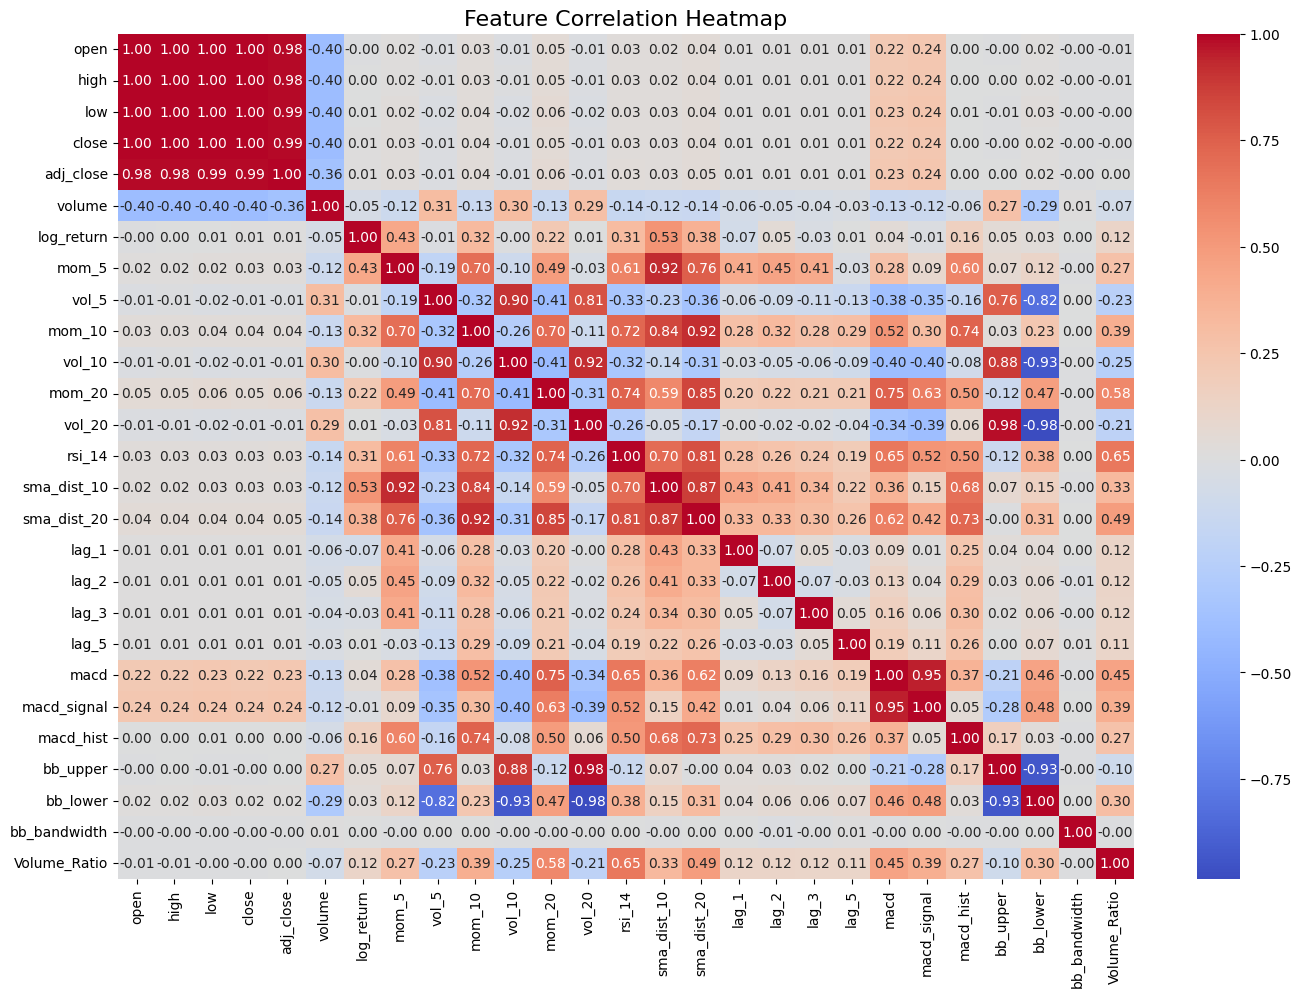

In [23]:
features = ['open','high','low','close','adj_close','volume', 'log_return', 'mom_5', 'vol_5', 'mom_10',
       'vol_10', 'mom_20', 'vol_20', 'rsi_14', 'sma_dist_10', 'sma_dist_20',
       'lag_1', 'lag_2', 'lag_3', 'lag_5', 'macd', 'macd_signal', 'macd_hist',
       'bb_upper', 'bb_lower', 'bb_bandwidth', 'Volume_Ratio']
plt.figure(figsize=(16, 12))  
sns.heatmap(prices[features].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Heatmap", fontsize=16)
plt.tight_layout(pad=8)
plt.show()



##### Saving the new DataFrame with all the new features.

In [24]:
prices.to_csv('prices_engineered.csv')

##### Having a peek at the engineered and cleaned data with all the new features. 

In [25]:
prices.head()

,date,ticker,open,high,low,close,adj_close,volume,log_return,mom_5,...,macd_signal,macd_hist,bb_upper,bb_lower,bb_bandwidth,up_vol,down_vol,up_vol_rolling,down_vol_rolling,Volume_Ratio
0,2010-02-02,XLE,56.509998,57.139999,56.049999,57.040001,34.003349,22250800,0.013058,0.002576,...,-0.600751,-0.241718,0.026016,-0.029072,-36.053110,22250800,0,167325600.0,256717500.0,0.651789
1,2010-02-03,XLE,56.880001,57.349998,56.419998,56.549999,33.711258,19749300,-0.008628,0.001634,...,-0.642156,-0.165621,0.024960,-0.029691,-23.100716,0,19749300,149957500.0,276466800.0,0.542407
2,2010-02-04,XLE,56.099998,56.119999,54.200001,54.230000,32.328228,37173200,-0.041891,-0.004630,...,-0.705018,-0.251446,0.026603,-0.036714,-12.524258,0,37173200,125605600.0,313640000.0,0.400477
3,2010-02-05,XLE,54.220001,54.480000,52.669998,54.240002,32.334187,46378400,0.000184,-0.000956,...,-0.776266,-0.284992,0.026736,-0.036678,-12.756206,46378400,0,171984000.0,296190500.0,0.580653
4,2010-02-08,XLE,54.250000,54.889999,53.730000,53.740002,32.036118,24115100,-0.009261,-0.009307,...,-0.855243,-0.315910,0.025530,-0.037047,-10.866376,0,24115100,158639700.0,320305600.0,0.495276


# Fitting models on the engineered data 

The ML Tester file uses the following inputs to ensure leak-proof walk forward testing. We will try to make our testing environment the same for evaluating models. Below is the description of the inputs.

- **Tickers** - The stocks to predict
- **File** - The input file which contains the prices
- **Start** - Date from which the window begins
- **End** - Date till when the window ends
- **Horizon** - model tries to predict the cumulative log return over the next 5 days. A larger horizon means the model is trying to predict further into the future, which is harder.
- **Steps** - This is the walk-forward step. The model is refit every $ N $ days. For example, it trains on all data before day 0, predicts the next $ N $ days, then refits on all data up to day $ N $, predicts the next $ N $ days, etc.
- **Out** - This is the folder where all results and CSVs are saved.

For context, the result for the basline student API given by the instructor gives the following outputs for the following inputs.    

` !python mltester.py  `
`--model ./student.py:Student `
`--tickers XLK XLP XLV `
`--data-file prices2.csv `                    
`--start 2015-01-01 --end 2019-12-31 `
`--horizon 5 --step 10 `
`--out-dir outputs `


| Ticker | DirAcc  | MAE      | RMSE     |
|--------|---------|----------|----------|
| XLK    | 0.4405  | 0.017776 | 0.023921 |
| XLP    | 0.4140  | 0.012459 | 0.016987 |
| XLV    | 0.4309  | 0.015827 | 0.021180 |



### Defining hyperparameters and inputs

In [26]:
horizon = 5       
step = 10         
start_date = '2015-01-01'
end_date   = '2019-12-31'
tickers =  ['XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLV']

feature_cols = ['log_return','mom_5','vol_5','mom_10','vol_10','mom_20','vol_20',
                'rsi_14','sma_dist_10','sma_dist_20','lag_1','lag_2','lag_3','lag_5',
                'macd','macd_signal','macd_hist','bb_upper','bb_lower','bb_bandwidth','Volume_Ratio']

device = "cuda" if torch.cuda.is_available() else "cpu"

# 1) XGBoost + Random forrest

This model employs ensemble learning techniques to enhance predictive accuracy and robustness compared to the baseline Logistic Regression model.

**Algorithms Used**

- **XGBoost (Extreme Gradient Boosting):**  
  A gradient-boosted decision tree algorithm that iteratively builds an ensemble of weak learners (trees), with each tree minimizing the residual errors of its predecessors. It includes regularization to prevent overfitting and is optimized for parallel computation and scalability. In this experiment, XGBoost uses `logloss` as the evaluation metric.

- **Random Forest:**  
  A bagging-based ensemble method that constructs multiple decision trees on random subsets of data and features. The final prediction is obtained by averaging across trees, which helps reduce variance and improve generalization.

**Model Configuration**

- **Base Model Used:** `XGBClassifier` with `n_estimators=100` and evaluation metric set to logloss.  
- **Feature Inputs:** 21 engineered financial indicators capturing momentum, volatility, RSI, SMA distances, MACD signals, Bollinger Bands, and volume ratios.

**Summary**

While Random Forests enhance model stability through randomness and aggregation, XGBoost boosts predictive strength via gradient-based optimization and sequential learning.  
Together, they balance bias-variance trade-off, yielding improved performance and robustness for financial time series forecasting tasks.


In [27]:
all_diracc = []

# Loop through each selected ticker
for t in tickers:
    # Filter data for the current ticker within the selected date range
    df = prices[prices['ticker'] == t].sort_values('date').reset_index(drop=True)
    df = df[(df['date'] >= start_date) & (df['date'] <= end_date)].reset_index(drop=True)

    # Target variable - H-day ahead cumulative log return
    df['target_horizon'] = np.log(df['close'].shift(-horizon) / df['close'])
    df = df.dropna(subset=['target_horizon']).reset_index(drop=True)

    y_preds = []
    y_trues = []

    # Rolling-window expanding training evaluation
    for start in range(0, len(df) - horizon, step):
        train_idx = range(0, start)  
        test_idx  = range(start, min(start + step, len(df) - horizon))

        # Skipping the current iteration if the training set is too samll
        if len(train_idx) < 20:
            continue

        # Split into train and test sets
        X_train = df.loc[train_idx, feature_cols]
        y_train = df.loc[train_idx, 'target_horizon']
        X_test  = df.loc[test_idx, feature_cols]
        y_test  = df.loc[test_idx, 'target_horizon']

        # Standardize training and test data
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled  = scaler.transform(X_test)

        # Train XGBoost regression model to predict future returns
        model = xgb.XGBRegressor(
            n_estimators=100,
            learning_rate=0.05,
            random_state=SEED,
            objective='reg:squarederror',
            eval_metric='rmse'
        )
        model.fit(X_train_scaled, y_train)

        # Predict on test window
        y_hat = model.predict(X_test_scaled)

        y_preds.extend(y_hat)
        y_trues.extend(y_test)

    y_preds = np.array(y_preds)
    y_trues = np.array(y_trues)

    # Computing performance tickers
    diracc = np.mean(np.sign(y_preds) == np.sign(y_trues))  
    mae = mean_absolute_error(y_trues, y_preds)
    rmse = np.sqrt(mean_squared_error(y_trues, y_preds))

    all_diracc.append(diracc)

    print(f"\nTicker: {t}")
    print(f"DirAcc: {diracc:.4f}")
    print(f"MAE: {mae:.6f}")
    print(f"RMSE: {rmse:.6f}")

mean_diracc = np.mean(all_diracc)


print(f"\nMean Directional Accuracy: {mean_diracc:.4f}")



Ticker: XLE
DirAcc: 0.5130
MAE: 0.024630
RMSE: 0.032942

Ticker: XLF
DirAcc: 0.5212
MAE: 0.019763
RMSE: 0.027007

Ticker: XLI
DirAcc: 0.4837
MAE: 0.018225
RMSE: 0.024289

Ticker: XLK
DirAcc: 0.5049
MAE: 0.019842
RMSE: 0.025988

Ticker: XLP
DirAcc: 0.5106
MAE: 0.013432
RMSE: 0.017921

Ticker: XLV
DirAcc: 0.5554
MAE: 0.016758
RMSE: 0.022849

Mean Directional Accuracy: 0.5148


# 2) LSTM

The LSTM model is designed to capture temporal dependencies in stock market data. Unlike traditional models that treat each observation independently, LSTMs are recurrent neural networks capable of learning sequential patterns over time, making them ideal for financial time series forecasting.

**Model Architecture:**
- **Input Layer:**  
  Each input vector consists of 21 engineered features, including momentum, volatility, RSI, SMA distances, MACD components, Bollinger Bands, and Volume Ratio.
- **LSTM Layer:**  
  A single-layer LSTM with 32 hidden units processes sequences of feature vectors. The model learns to retain long-term dependencies and identify time-based signals in stock price movements.
- **Fully Connected Layer:**  
  The output from the last time step is passed through a fully connected (Linear) layer to produce a single scalar output.
- **Activation Function:**  
  A Sigmoid activation maps outputs to a probability in the range [0, 1], representing the likelihood of the stock price increasing after the prediction horizon.
- **Loss Function:**  
  Binary Cross-Entropy Loss (BCELoss) is used to optimize the binary classification objective.
- **Optimizer:**  
  The model is trained using the Adam optimizer with a learning rate of 0.001.

**Summary:**
LSTMs capture sequential dependencies that traditional machine learning models like Logistic Regression or XGBoost may overlook. By retaining information from prior time steps, they are better suited for modeling momentum shifts, volatility patterns, and lagged indicators in stock price data. This enables more dynamic and adaptive forecasting of market direction.


In [ ]:
class StockLSTMReg(nn.Module):
    def __init__(self, input_size, hidden_size=32, num_layers=3):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  
        out = self.fc(out)   
        return out

In [29]:
all_metrics = []

for t in tickers:
    df = prices[prices['ticker'] == t].sort_values('date').reset_index(drop=True)
    df = df[(df['date'] >= start_date) & (df['date'] <= end_date)].reset_index(drop=True)

    df['target_horizon'] = np.log(df['close'].shift(-horizon) / df['close'])
    df = df.dropna(subset=['target_horizon']).reset_index(drop=True)

    y_preds_all = []
    y_trues_all = []

    for start in range(0, len(df) - horizon, step):
        train_idx = range(0, start)
        test_idx  = range(start, min(start + step, len(df) - horizon))

        if len(train_idx) < 20:
            continue

        X_train = df.loc[train_idx, feature_cols].values
        y_train = df.loc[train_idx, 'target_horizon'].values
        X_test  = df.loc[test_idx, feature_cols].values
        y_test  = df.loc[test_idx, 'target_horizon'].values

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled  = scaler.transform(X_test)

        # 3D input for LSTM - (batch, sequence_length, features)
        X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).unsqueeze(1).to(device)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
        X_test_tensor  = torch.tensor(X_test_scaled, dtype=torch.float32).unsqueeze(1).to(device)
        y_test_tensor  = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)

        # Using PyTorch DataLoader for batching 
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

        # LSTM model initialization 
        model = StockLSTMReg(input_size=X_train.shape[1]).to(device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        epochs = 24 

        # Training loop
        model.train()
        for epoch in range(epochs):
            for xb, yb in train_loader:
                optimizer.zero_grad()
                out = model(xb)        
                loss = criterion(out, yb)
                loss.backward()
                optimizer.step()

        # Model evaluation 
        model.eval()
        with torch.no_grad():
            y_pred = model(X_test_tensor).squeeze(-1).cpu().numpy()

        y_preds_all.extend(y_pred)
        y_trues_all.extend(y_test)

    y_preds_all = np.array(y_preds_all)
    y_trues_all = np.array(y_trues_all)

    mae = mean_absolute_error(y_trues_all, y_preds_all)
    rmse = np.sqrt(mean_squared_error(y_trues_all, y_preds_all))

    diracc = np.mean((y_preds_all > 0) == (y_trues_all > 0))
    all_metrics.append(diracc)

    print(f"\nTicker: {t}")
    print(f"DirAcc: {diracc:.4f}, MAE: {mae:.6f}, RMSE: {rmse:.6f}")

mean_diracc = np.mean(all_metrics)
print(f"\nMean Directional Accuracy: {mean_diracc:.4f}")



Ticker: XLE
DirAcc: 0.4886, MAE: 0.024691, RMSE: 0.032921

Ticker: XLF
DirAcc: 0.5147, MAE: 0.019109, RMSE: 0.025976

Ticker: XLI
DirAcc: 0.5252, MAE: 0.017821, RMSE: 0.024189

Ticker: XLK
DirAcc: 0.5130, MAE: 0.020268, RMSE: 0.027158

Ticker: XLP
DirAcc: 0.5033, MAE: 0.013631, RMSE: 0.017948

Ticker: XLV
DirAcc: 0.5399, MAE: 0.016910, RMSE: 0.023039

Mean Directional Accuracy: 0.5141


The LSTM did not perform as good despite the fact it is great for sequential data because it is a highly complex model, and it needs a larger dataset to be accurate. LSTMs also struggle if the target is too volatile or stochastic. 

A Bi-Directional LSTM could perform better but since were making a leakage proof and walk forward model, it would not be ideal.


In the following code cells, models that are particularly suitable for finance data are applied. 


Sources : 
- [CFI - Ridge regression](https://corporatefinanceinstitute.com/resources/data-science/ridge/)
- [Reddit - Ridge regression](https://www.reddit.com/r/algotrading/comments/1iliivd/is_it_realistic_to_use_ridge_regression_for/)
- [Geeks for Geeks - Lasso Regression](https://www.geeksforgeeks.org/machine-learning/what-is-lasso-regression/)
- [Medium - Lasso Regression](https://medium.com/@data-overload/lasso-regression-6cf77cfe8ea4)

# 3) Ridge Regression

The Ridge Regression model is a linear regression technique that incorporates L2 regularization to prevent overfitting. It is particularly useful for financial time series where multicollinearity among features (e.g., momentum, volatility, technical indicators) may exist.

**Model Overview:**
- **Input Features:**  
  21 engineered features including momentum, volatility, RSI, SMA distances, MACD components, Bollinger Bands, and Volume Ratio.
- **Ridge Regression:**  
  A linear model that minimizes the sum of squared errors with an added L2 penalty term proportional to the square of the coefficients. This discourages overly large weights, improving generalization.
- **Regularization Parameter (alpha):**  
  Controls the strength of the penalty; higher values reduce overfitting but may underfit the data.
- **Target Variable:**  
  Next _H_ day cumulative log return $ y_t = \log(C_{t+H}/C_t) $, allowing the model to predict price movement magnitude.
- **Optimization:**  
  Solved via closed-form linear algebra or iterative solvers depending on the library implementation.

**Summary:**  
Ridge Regression offers a simple yet effective approach to predict stock returns while mitigating multicollinearity among features. Unlike tree-based or deep learning models, it assumes a linear relationship between input features and returns, providing interpretable coefficients and stable predictions in high-dimensional financial datasets.


In [30]:
all_diracc = []

for t in tickers:
    df = prices[prices['ticker'] == t].sort_values('date').reset_index(drop=True)
    df = df[(df['date'] >= start_date) & (df['date'] <= end_date)].reset_index(drop=True)

    df['target_horizon'] = np.log(df['close'].shift(-horizon) / df['close'])
    df = df.dropna(subset=['target_horizon']).reset_index(drop=True)

    y_preds = []
    y_trues = []

    for start in range(0, len(df) - horizon, step):
        train_idx = range(0, start)
        test_idx  = range(start, min(start + step, len(df) - horizon))

        if len(train_idx) < 20:
            continue

        X_train = df.loc[train_idx, feature_cols].values
        y_train = df.loc[train_idx, 'target_horizon'].values
        X_test  = df.loc[test_idx, feature_cols].values
        y_test  = df.loc[test_idx, 'target_horizon'].values

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled  = scaler.transform(X_test)

        # Ridge Regression model 
        model = Ridge(alpha=1.0, random_state=SEED)
        model.fit(X_train_scaled, y_train)

        # Predict on test data
        y_hat = model.predict(X_test_scaled)

        y_preds.extend(y_hat)
        y_trues.extend(y_test)

    y_preds = np.array(y_preds)
    y_trues = np.array(y_trues)

    diracc = np.mean(np.sign(y_preds) == np.sign(y_trues))

    all_diracc.append(diracc)

    print(f"\nTicker: {t}")
    print(f"DirAcc: {diracc:.4f}")
    print(f"MAE: {mae:.6f}")
    print(f"RMSE: {rmse:.6f}")

mean_diracc = np.mean(all_diracc)
print(f"\nMean Directional Accuracy: {mean_diracc:.4f}")



Ticker: XLE
DirAcc: 0.4992
MAE: 0.016910
RMSE: 0.023039

Ticker: XLF
DirAcc: 0.5212
MAE: 0.016910
RMSE: 0.023039

Ticker: XLI
DirAcc: 0.5309
MAE: 0.016910
RMSE: 0.023039

Ticker: XLK
DirAcc: 0.5073
MAE: 0.016910
RMSE: 0.023039

Ticker: XLP
DirAcc: 0.5187
MAE: 0.016910
RMSE: 0.023039

Ticker: XLV
DirAcc: 0.5432
MAE: 0.016910
RMSE: 0.023039

Mean Directional Accuracy: 0.5201


# 4) Lasso Regression

The Lasso Regression model is a linear regression technique that incorporates L1 regularization to perform both shrinkage and feature selection. It is particularly useful for financial time series where many features may be irrelevant or redundant.

**Model Overview:**
- **Input Features:**  
  21 engineered features including momentum, volatility, RSI, SMA distances, MACD components, Bollinger Bands, and Volume Ratio.
- **Lasso Regression:**  
  A linear model that minimizes the sum of squared errors with an added L1 penalty term proportional to the absolute values of the coefficients. This encourages sparsity, effectively setting some feature weights to zero.
- **Regularization Parameter (alpha):**  
  Controls the strength of the L1 penalty; higher values increase sparsity and reduce overfitting but may discard useful features.
- **Target Variable:**  
  Next _H_ day cumulative log return $ y_t = \log(C_{t+H}/C_t) $, allowing the model to predict price movement magnitude.
- **Optimization:**  
  Solved using iterative methods like coordinate descent due to the non-differentiable L1 penalty.

**Summary:**  
Lasso Regression provides an interpretable, linear approach for predicting stock returns while performing automatic feature selection. By shrinking less important coefficients to zero, it helps reduce overfitting and highlights the most influential technical indicators in high-dimensional financial datasets.


In [31]:
all_diracc = []

for t in tickers:
    df = prices[prices['ticker'] == t].sort_values('date').reset_index(drop=True)
    df = df[(df['date'] >= start_date) & (df['date'] <= end_date)].reset_index(drop=True)

    df['target_horizon'] = np.log(df['close'].shift(-horizon) / df['close'])
    df = df.dropna(subset=['target_horizon']).reset_index(drop=True)

    y_preds = []
    y_trues = []

    for start in range(0, len(df) - horizon, step):
        train_idx = range(0, start)
        test_idx  = range(start, min(start + step, len(df) - horizon))

        if len(train_idx) < 20:
            continue

        X_train = df.loc[train_idx, feature_cols].values
        y_train = df.loc[train_idx, 'target_horizon'].values
        X_test  = df.loc[test_idx, feature_cols].values
        y_test  = df.loc[test_idx, 'target_horizon'].values


        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled  = scaler.transform(X_test)

        # Lasso Regression model 
        model = Lasso(alpha=0.01, random_state=SEED)
        model.fit(X_train_scaled, y_train)

        y_hat = model.predict(X_test_scaled)

        y_preds.extend(y_hat)
        y_trues.extend(y_test)

    y_preds = np.array(y_preds)
    y_trues = np.array(y_trues)

    diracc = np.mean(np.sign(y_preds) == np.sign(y_trues))

    all_diracc.append(diracc)

    print(f"\nTicker: {t}")
    print(f"DirAcc: {diracc:.4f}")
    print(f"MAE: {mae:.6f}")
    print(f"RMSE: {rmse:.6f}")



mean_diracc = np.mean(all_diracc)

print(f"\nMean Directional Accuracy: {mean_diracc:.4f}")



Ticker: XLE
DirAcc: 0.4601
MAE: 0.016910
RMSE: 0.023039

Ticker: XLF
DirAcc: 0.5228
MAE: 0.016910
RMSE: 0.023039

Ticker: XLI
DirAcc: 0.5546
MAE: 0.016910
RMSE: 0.023039

Ticker: XLK
DirAcc: 0.5912
MAE: 0.016910
RMSE: 0.023039

Ticker: XLP
DirAcc: 0.5529
MAE: 0.016910
RMSE: 0.023039

Ticker: XLV
DirAcc: 0.5358
MAE: 0.016910
RMSE: 0.023039

Mean Directional Accuracy: 0.5362


# 5) Partial Least Squares (PLS) Feature Extraction for Feature Extraction

**Partial Least Squares (PLS)** is a dimensionality reduction technique that extracts new features from the original dataset while taking into account the relationship between the input features and the target variable. 

**How PLS Works:**
- PLS projects the original features into a smaller set of latent components.
- These components are linear combinations of the original features.
- Unlike PCA, which focuses only on maximizing variance in the features, PLS also maximizes the covariance with the target variable.
- This means the extracted features are more predictive of the output, improving model performance when dealing with multicollinearity or many correlated features.

**Effect on Data:**
- Original features (e.g., `log_return`, `mom_5`, `vol_5`, etc.) are transformed into a smaller set of components (e.g., 5 PLS components).
- Each new feature represents a combination of original features that best explains the target.
- Reduces dimensionality, mitigates noise, and improves the learning efficiency of models like CNN, LSTM, or XGBoost.

**Example:**  
Original feature matrix `X` with shape `(num_samples, num_features)` → PLS-transformed matrix `X_pls` with shape `(num_samples, n_components)`.

This helps models focus on the most informative directions in the data. In the following code cells, PLS is applied on the data before training on the Ridge and Lasso models. 


In [32]:
# Number of PLS components
n_components = 5

## 5.1) Ridge + PLS

In [33]:
all_diracc = []


for t in tickers:
    df = prices[prices['ticker'] == t].sort_values('date').reset_index(drop=True)
    df = df[(df['date'] >= start_date) & (df['date'] <= end_date)].reset_index(drop=True)

    df['target_horizon'] = np.log(df['close'].shift(-horizon) / df['close'])
    df = df.dropna(subset=['target_horizon']).reset_index(drop=True)

    y_preds_all = []
    y_trues_all = []

    for start in range(0, len(df) - horizon, step):
        train_idx = range(0, start)
        test_idx  = range(start, min(start + step, len(df) - horizon))

        if len(train_idx) < 20:
            continue

        X_train = df.loc[train_idx, feature_cols].values
        y_train = df.loc[train_idx, 'target_horizon'].values
        X_test  = df.loc[test_idx, feature_cols].values
        y_test  = df.loc[test_idx, 'target_horizon'].values

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled  = scaler.transform(X_test)

        # Applying PLS
        pls = PLSRegression(n_components=n_components)
        X_train_pls = pls.fit_transform(X_train_scaled, y_train)[0]
        X_test_pls  = pls.transform(X_test_scaled)

        # Ridge Regression on PLS components
        model = Ridge(alpha=1.0)
        model.fit(X_train_pls, y_train)
        y_pred = model.predict(X_test_pls)

        y_preds_all.extend(y_pred)
        y_trues_all.extend(y_test)

    y_preds_all = np.array(y_preds_all)
    y_trues_all = np.array(y_trues_all)

    diracc = np.mean((y_preds_all > 0) == (y_trues_all > 0))


    all_diracc.append(diracc)


    print(f"\nTicker: {t}")
    print(f"DirAcc: {diracc:.4f}")
    print(f"MAE: {mae:.6f}")
    print(f"RMSE: {rmse:.6f}")

print(f"\nMean Directional Accuracy: {np.mean(all_diracc):.4f}")


Ticker: XLE
DirAcc: 0.5098
MAE: 0.016910
RMSE: 0.023039

Ticker: XLF
DirAcc: 0.5448
MAE: 0.016910
RMSE: 0.023039

Ticker: XLI
DirAcc: 0.5358
MAE: 0.016910
RMSE: 0.023039

Ticker: XLK
DirAcc: 0.5065
MAE: 0.016910
RMSE: 0.023039

Ticker: XLP
DirAcc: 0.5269
MAE: 0.016910
RMSE: 0.023039

Ticker: XLV
DirAcc: 0.5440
MAE: 0.016910
RMSE: 0.023039

Mean Directional Accuracy: 0.5280


## 5.2) Lasso + PLS

In [34]:
all_diracc = []


for t in tickers:
    df = prices[prices['ticker'] == t].sort_values('date').reset_index(drop=True)
    df = df[(df['date'] >= start_date) & (df['date'] <= end_date)].reset_index(drop=True)

    df['target_horizon'] = np.log(df['close'].shift(-horizon) / df['close'])
    df = df.dropna(subset=['target_horizon']).reset_index(drop=True)

    y_preds = []
    y_trues = []

    for start in range(0, len(df) - horizon, step):
        train_idx = range(0, start)
        test_idx  = range(start, min(start + step, len(df) - horizon))

        if len(train_idx) < 20:
            continue

        X_train = df.loc[train_idx, feature_cols].values
        y_train = df.loc[train_idx, 'target_horizon'].values
        X_test  = df.loc[test_idx, feature_cols].values
        y_test  = df.loc[test_idx, 'target_horizon'].values


        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled  = scaler.transform(X_test)

        # Applying PLS
        pls = PLSRegression(n_components=n_components)
        X_train_pls = pls.fit_transform(X_train_scaled, y_train)[0]  
        X_test_pls  = pls.transform(X_test_scaled)

        # Lasso Regression on PLS components
        model = Lasso(alpha=0.01, random_state=SEED)
        model.fit(X_train_pls, y_train)

        y_hat = model.predict(X_test_pls)

        y_preds.extend(y_hat)
        y_trues.extend(y_test)

    y_preds = np.array(y_preds)
    y_trues = np.array(y_trues)

    diracc = np.mean(np.sign(y_preds) == np.sign(y_trues))
   

    all_diracc.append(diracc)


    print(f"\nTicker: {t}")
    print(f"DirAcc: {diracc:.4f}")
    print(f"MAE: {mae:.6f}")
    print(f"RMSE: {rmse:.6f}")

mean_diracc = np.mean(all_diracc)


print(f"\nMean Directional Accuracy: {mean_diracc:.4f}")




Ticker: XLE
DirAcc: 0.4739
MAE: 0.016910
RMSE: 0.023039

Ticker: XLF
DirAcc: 0.5261
MAE: 0.016910
RMSE: 0.023039

Ticker: XLI
DirAcc: 0.5603
MAE: 0.016910
RMSE: 0.023039

Ticker: XLK
DirAcc: 0.5936
MAE: 0.016910
RMSE: 0.023039

Ticker: XLP
DirAcc: 0.5717
MAE: 0.016910
RMSE: 0.023039

Ticker: XLV
DirAcc: 0.5513
MAE: 0.016910
RMSE: 0.023039

Mean Directional Accuracy: 0.5461


# Evaluating the Results

| Model                                     | Mean Directional Accuracy |
|-------------------------------------------|----------------------------|
| XGBoost + Random forrest                    | 0.5148                     |
| LSTM                                    | 0.5043                       |
| Ridge Regression                             | 0.5201                     |
| Lasso Regression                            | 0.5362                   |
| Ridge + PLS                                 | 0.5280                    |
| Lasso + PLS                                 | 0.5461                |

In Conclusion, Lasso + PLS works the best. This model will be used in `Student.py` file along with the feature extraction methods described above. Which will be tested by the `ML Tester` with a leakage safe walk forward methodology.

In [39]:
!python mltester.py --model ./student.py:Student --tickers XLE XLF XLI XLK XLP XLV --data-file prices2.csv --start "2010-01-01" --end "2015-12-31" --horizon 5 --step 10 --out-dir outputs

   XLE: DirAcc=0.5017  MAE=0.023444  RMSE=0.032404
   XLF: DirAcc=0.5249  MAE=939762.644707  RMSE=36457460.887501
   XLI: DirAcc=0.5621  MAE=0.019068  RMSE=0.025951
   XLK: DirAcc=0.5528  MAE=0.017339  RMSE=0.023110
   XLP: DirAcc=0.5708  MAE=0.011843  RMSE=0.015741
   XLV: DirAcc=0.5934  MAE=0.015051  RMSE=0.020152
Saved outputs to /home/umer/Desktop/MS AI/Machine Learning/Assignment1/outputs
